In [1]:
%matplotlib inline

In [2]:
import keras
from skimage import data, img_as_float
from skimage import exposure
from skimage import io
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import rescale
import matplotlib.image as mpimg


from sklearn.utils import class_weight
import pandas as pd

Using TensorFlow backend.


In [3]:
DATASET_PATH = '/home/nikhil/Desktop/Unscript_hackathon/HAM_10000'

disease_cls = ['Actinic_Keratoses', 'Basal_cell_carcinoma', 'Benign_keratosis', 'Dermatofibroma', 'Melanoma',
               'Melanocytic_nevi', 'Vascular_skin_lesions', 'Normal_skin', 'Acne']

In [4]:
final_paths= list()
labels= dict()

for i, cls in enumerate(disease_cls):
    paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
    final_paths += paths
    labels.update({p:i for p in paths})
    
y_train= np.array(list(labels.values()))


# df= pd.read_csv("/home/nikhil/Desktop/Unscript_hackathon/HAM10000_metadata.csv")
# dx= np.array(df.dx)

# y_train= np.array(dx)

unique= np.unique(y_train)

weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights= dict()

for (key, value) in enumerate(weights):
    class_weights[key]= value

print(class_weights)

{0: 2.1032741205154997, 1: 1.5248737373737373, 2: 0.980912930474334, 3: 4.16735679779158, 4: 1.0483506944444445, 5: 0.19806478064780647, 6: 7.025596276905177, 7: 3.5406039284667252, 8: 5.499544626593807}


In [5]:
len(labels)

12077

In [6]:
print("Keras File path:",keras.__file__)
print('Keras version:', keras.__version__)

Keras File path: /home/nikhil/.virtualenvs/DL/lib/python3.6/site-packages/keras/__init__.py
Keras version: 2.2.4


## Augmentations

In [6]:
# from imgaug import augmenters as iaa

# seq = iaa.Sequential([...])  # list of desired augmentors

# ig = ImageDataGenerator(preprocessing_function=seq.augment_image)  # pass this as the preprocessing function

# gen = ig.flow_from_directory(data_dir)  # nothing else changes with the generator

In [7]:
ablation = 2
list_IDs= list()
labels= dict()

for i, cls in enumerate(disease_cls):
    paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))

    if ablation is not None:
        paths = paths[:int(len(paths)*ablation/100)]

    list_IDs += paths
    labels.update({p:i for p in paths})

x_train= list()
img_rows, img_cols= 224, 224

def scale(img):
    img = (img - img.min())/(img.max() - img.min())
    return img

for path in list_IDs:
    img= mpimg.imread(path)
    img = scale(img)
    img= cv2.resize(img, (img_rows, img_cols))
    x_train.append(img)

print("x_train:", np.array(x_train).shape)
# x_train= np.array(x_train)

ValueError: could not broadcast input array from shape (224,224,3) into shape (224,224)

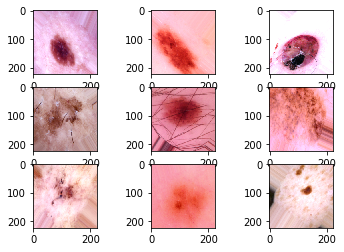

In [7]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=90,
    width_shift_range=0.15,
    height_shift_range=0.15,
    vertical_flip=True,
    horizontal_flip= True,
    brightness_range=[0.5, 1.5],
    zoom_range=0.2,
    shear_range= 0.2)


# fit parameters from data
datagen.fit(x_train)

# cv2.resize(image, (224,224), interpolation = inter)

# Configure batch size and retrieve one batch of images
for X_batch in datagen.flow(x_train, batch_size=9):    
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(scale(X_batch[i]))

    plt.show()
    break

In [7]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=90,
#     width_shift_range=0.15,
#     height_shift_range=0.15,
    vertical_flip=True,
    horizontal_flip= True,
    brightness_range=[0.5, 1.5])
#     zoom_range=0.2,
#     shear_range= 0.2)

___

___

## Resnet Model

In [7]:
import cv2
import numpy as np
import copy
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Flatten, Activation, add, Dropout
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import initializers
from keras.engine import Layer, InputSpec
from keras import backend as K

## Import the Resnet Model

In [8]:
from keras.applications.resnet50 import ResNet50
model= ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling=None)

/home/nikhil/.virtualenvs/DL/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Make all layers except the last 4 layers non-trainable

In [10]:
for layer in model.layers[:-3]:
    layer.trainable = False

In [11]:
new_model = Sequential()
n_classes= len(disease_cls)

new_model.add(model)
 
# Add new layers
new_model.add(Flatten())
new_model.add(Dense(512, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(n_classes, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 4617      
Total params: 74,973,065
Trainable params: 51,389,449
Non-trainable params: 23,583,616
_________________________________________________________________


## Data Generator

(224, 224, 3)


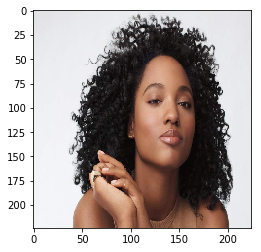

In [12]:
img_rows= 224
img_cols= 224

def preprocess_img(img, mode):
    
#     if mode == 'train':
#         img = datagen.random_transform(img)

    img= cv2.resize(img, (img_rows, img_cols))
    
    if(img.shape == (224, 224, 4)):
        img= img[:, :, :-1]

    elif(img.shape == (224, 224)):  
        img = np.stack((img,)*3, axis=-1)

    elif(img.shape == (224, 224, 1)):  
        img = np.stack((img,)*3, axis=-1)

    img = (img - img.min())/(img.max() - img.min())
    
    return img


image= mpimg.imread("/home/nikhil/Desktop/Unscript_hackathon/HAM_10000/Normal_skin/2. best-foundations-black-skin.jpg")
img= preprocess_img(image, mode= 'test')
plt.imshow(img)
print(img.shape)

def scale(img):
    img= (img - img.min())/(img.max() - img.min())
    return img

In [13]:
ran= np.random.rand(224, 224, 1)
ran_img= preprocess_img(ran, mode= 'test')
# plt.imshow(ran_img)
ran_img.shape

(224, 224, 3)

In [14]:
img= mpimg.imread("/home/nikhil/Desktop/Unscript_hackathon/HAM_10000/Acne/kdl.JPG")
img= preprocess_img(img, 'val')
img.shape

(224, 224, 3)

In [15]:
import numpy as np
import keras

augments= 1
BATCH_SIZE= 50 * augments

class AugmentedDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = disease_cls, 
                 batch_size=BATCH_SIZE, dim=(224, 224), n_channels=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.9)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})

        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / (self.batch_size//augments)))

    def __getitem__(self, index):
        'Generate one batch of data'
        
        indexes = self.indexes[index * self.batch_size//augments: (index+1) * self.batch_size//augments]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
           
        for i, ID in enumerate(list_IDs_temp):
            img = mpimg.imread(ID)
            for j in range(augments):
                image = preprocess_img(img, self.mode)
                X[i*augments + j,] = image
                y[i*augments + j] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [16]:
# training_generator = AugmentedDataGenerator('train')
# validation_generator = AugmentedDataGenerator('val')

In [17]:
# new_model.compile(loss= 'categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

# new_model.fit_generator(generator=training_generator,
#                     validation_data=validation_generator,
#                     epochs=1, class_weight= class_weights)

## ROC_AUC Callback

In [18]:
from sklearn.metrics import roc_auc_score
from keras import optimizers
from keras.callbacks import *

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

## Tensorboard Callback

Run this in terminal: <br/>
tensorboard --logdir path_to_current_dir/logs 

In [19]:
tb_callback= keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=BATCH_SIZE, write_graph=False)

## Cyclical Learning Rate

In [20]:
from CLR_master.clr_callback import *

clr_triangular = CyclicLR(mode='triangular', base_lr= 0.0001,max_lr= 0.0005, step_size= 600)

In [21]:
# plt.xlabel('Training Iterations')
# plt.ylabel('Learning Rate')
# plt.title("CLR - 'triangular' Policy")
# plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

## Model Checkpoint

In [22]:
checkpoint= keras.callbacks.ModelCheckpoint("best_model/model.hdf5", monitor='val_loss', verbose=0, 
                                save_best_only=True, mode='min', period=1)

In [23]:
new_model.compile(loss='categorical_crossentropy' ,optimizer= 'RMSprop', metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train')
validation_generator = AugmentedDataGenerator('val')

auc_logger = roc_callback()
filepath = 'models/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

new_model.fit_generator(generator= training_generator,
                    validation_data= validation_generator,
                    epochs=200 , callbacks= [clr_triangular, auc_logger, tb_callback, checkpoint],
                    class_weight= class_weights)

Epoch 1/200
217/217 [==============================] - 193s 890ms/step - loss: 7.2267 - acc: 0.5266 - val_loss: 2.1536 - val_acc: 0.5600

Val AUC for epoch0: 0.3783644400503128

Epoch 00001: val_auc improved from -inf to 0.37836, saving model to models/best_model.hdf5
Epoch 2/200
217/217 [==============================] - 184s 847ms/step - loss: 2.1862 - acc: 0.5772 - val_loss: 3.4463 - val_acc: 0.5608

Val AUC for epoch1: 0.4091115358694347

Epoch 00002: val_auc improved from 0.37836 to 0.40911, saving model to models/best_model.hdf5
Epoch 3/200
217/217 [==============================] - 184s 847ms/step - loss: 2.1065 - acc: 0.6327 - val_loss: 7.0393 - val_acc: 0.5600

Val AUC for epoch2: 0.35924081163096416

Epoch 00003: val_auc did not improve from 0.40911
Epoch 4/200
217/217 [==============================] - 184s 848ms/step - loss: 1.6041 - acc: 0.7016 - val_loss: 7.0920 - val_acc: 0.5600

Val AUC for epoch3: 0.37468806869462723

Epoch 00004: val_auc did not improve from 0.40911
E

KeyboardInterrupt: 

## Class Weights

In [21]:
disease_cls

['Actinic_Keratoses',
 'Basal_cell_carcinoma',
 'Benign_keratosis',
 'Dermatofibroma',
 'Melanoma',
 'Melanocytic_nevi',
 'Vascular_skin_lesions',
 'Normal_skin',
 'Acne']

{0: 2.116675096948238, 1: 1.5228044638524987, 2: 1.0020753512132823, 3: 4.078622482131254, 4: 1.0013559862806094, 5: 0.2023044073805495, 6: 4.414205344585091, 7: 3.558390022675737, 8: 5.601963409192325}
